# Differential Methylation

Import everything from the imports notebook. This reads in all of the expression data as well as the functions needed to analyse differential expression data.

In [1]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

__matched_tn__ is our matched expression data.

In [2]:
store = '/data_ssd/TCGA_methylation_2014_04_16.h5'
matched_tn = pd.read_hdf(store, 'matched_tn')
matched_tn = matched_tn.groupby(axis=1, level=[0,1]).first()

In [3]:
matched_tn.T.head(10).T.head()

TCGA-05-5420        TCGA-18-3417        TCGA-18-4721        TCGA-18-5592        TCGA-18-5595      
                             01    11            01    11            01    11            01    11            01    11
Hybridization REF                                                                                                    
cg00000029                 0.38  0.18          0.23  0.18          0.31  0.24          0.17  0.25          0.16  0.16
cg00000165                 0.15  0.11          0.51  0.15          0.40  0.15          0.74  0.14          0.80  0.18
cg00000236                 0.85  0.92          0.91  0.85          0.87  0.88          0.91  0.90          0.90  0.89
cg00000289                 0.71  0.75          0.73  0.77          0.64  0.81          0.67  0.76          0.74  0.77
cg00000292                 0.75  0.71          0.67  0.69          0.77  0.68          0.51  0.68          0.59  0.69

###Run a simple screen for DX probes 
* Here we take the matched expression data and fun a basic screen
* fc = 1 means that we have no foldchange buffer for a gene to be considered over or underexpressed in a patient

In [4]:
def memoize(f):
    memo = {}
    def helper(x,y,z):
        if (x,y,z) not in memo:            
            memo[(x,y,z)] = f(x,y,z)
        return memo[(x,y,z)]
    return helper

binom_test_mem = memoize(binom_test)

def binomial_test_screen(df, fc=1.5, p=.5):
    """
    Run a binomial test on a DataFrame.

    df:
        DataFrame of measurements.  Should have a multi-index with
        subjects on the first level and tissue type ('01' or '11')
        on the second level.
    fc:
        Fold-chance cutoff to use
    """
    a, b = df.xs('01', 1, 1), df.xs('11', 1, 1)
    dx = a - b
    dx = dx[dx.abs() > np.log2(fc)]
    n = dx.count(1)
    counts = (dx > 0).sum(1)
    cn = pd.concat([counts, n], 1)
    cn = cn[cn.sum(1) > 0]
    b_test = cn.apply(lambda s: binom_test_mem(s[0], s[1], p), axis=1)
    dist = (1.*cn[0] / cn[1])
    tab = pd.concat([cn[0], cn[1], dist, b_test],
                    keys=['num_ox', 'num_dx', 'frac', 'p'],
                    axis=1)
    return tab


In [161]:
from Figures.Boxplots import _violin_plot

In [174]:
def smooth_dist(vec, bins=300):
    """
    Calculate smoothed distribution given a real valued Series of data.
    Data should be relatively large as to not suffer from sampling effects
    I'm using this for methylation data with 450,000 measurments.  For
    smaller arrays, condider doing a KDE based visualization.

    What I do here is calculate a count across a discrete number of bins
    and then smooth the distribution with a rolling mean.
    """
    h = np.histogram(vec.dropna(), bins=bins, normed=True)
    #bw = int(bins / 15)
    s = pd.rolling_mean(pd.Series(h[0], index=h[1][1:]), 20, center=True)
    return s

def draw_dist(vec, split=None, ax=None, legend=True, colors=None, lw=2, bins=300):
    """
    Draw a smooth distribution from data with an optional splitting factor.
    """
    _, ax = init_ax(ax)
    if split is None:
        split = pd.Series('s', index=vec.index)
        colors = {'s': colors} if colors is not None else None
    for l,v in vec.groupby(split):
        if colors is None:
            smooth_dist(v, bins=bins).plot(label=l, lw=lw, ax=ax)
        else:
            smooth_dist(v, bins=bins).plot(label=l, lw=lw, ax=ax, color=colors[l])
    if legend and len(split.unique()) > 1:
        ax.legend(loc='upper left', frameon=False)

In [5]:
matched_rna = pd.read_hdf('/data_ssd/RNASeq_2014_07_15.h5', 'matched_tn')
dx_genes = binomial_test_screen(matched_rna, fc=1.)
dx_genes = dx_genes[dx_genes.num_dx > 300]

In [137]:
rr = screen_feature(dx_genes.frac, rev_kruskal, gene_sets.ix[dx_genes.index].fillna(0).T, 
                    align=False)
fp = (1.*gene_sets.T * dx_genes.frac).T.dropna().replace(0, nan).mean().order()

In [138]:
rr.ix[ti(fp < .5)].sort('p').head()

,H,p,q
REACTOME_BIOLOGICAL_OXIDATIONS,50.47,1.21e-12,1.98e-11
REACTOME_PHASE_1_FUNCTIONALIZATION_OF_COMPOUNDS,43.64,3.95e-11,5.36e-10
KEGG_FATTY_ACID_METABOLISM,43.62,3.99e-11,5.36e-10
KEGG_DRUG_METABOLISM_CYTOCHROME_P450,43.12,5.14e-11,6.78e-10
REACTOME_DOWNSTREAM_EVENTS_IN_GPCR_SIGNALING,38.79,4.71e-10,5.94e-09


In [139]:
rr.head()

,H,p,q
REACTOME_CELL_CYCLE_MITOTIC,260.31,1.47e-58,1.22e-55
REACTOME_MITOTIC_M_M_G1_PHASES,178.90,8.41e-41,3.50e-38
REACTOME_GENE_EXPRESSION,160.35,9.48e-37,2.63e-34
REACTOME_S_PHASE,157.14,4.77e-36,9.93e-34
REACTOME_CELL_CYCLE_CHECKPOINTS,153.10,3.64e-35,6.05e-33


In [145]:
gs2 = gene_sets.ix[dx_genes.index].fillna(0)

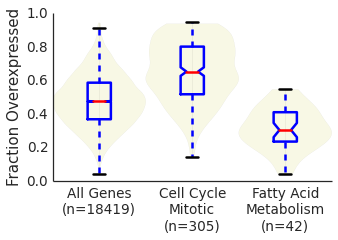

In [209]:
fig, ax = subplots(1,1, figsize=(5,3))
v = pd.concat([dx_genes.frac, 
               dx_genes.frac.ix[ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)],
               dx_genes.frac.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)]])

v1 = pd.concat([pd.Series('All Genes', dx_genes.frac.index), 
                pd.Series('Cell Cycle\nMitotic', ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)),
                pd.Series('Fatty Acid\nMetabolism', ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0))])
v1.name = ''
v.name = 'Fraction Overexpressed'
violin_plot_pandas(v1, v, ann=None, ax=ax)
prettify_ax(ax)

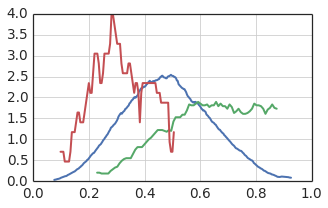

In [210]:
fig, ax = subplots(1,1, figsize=(5,3))
draw_dist(dx_genes.frac, bins=300, ax=ax)
draw_dist(dx_genes.frac.ix[ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)], bins=100, ax=ax)
draw_dist(dx_genes.frac.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)], bins=100, ax=ax)

In [73]:
matched_mir = pd.read_hdf('/data_ssd/miRNASeq_2014_07_15.h5', 'matched_tn')
dx_mir = binomial_test_screen(matched_mir, fc=1.)
dx_mir = dx_mir[dx_mir.num_dx > 300]

In [76]:
dx_mir.sort('p').head()

,num_ox,num_dx,frac,p
hsa-mir-21,581,628,0.93,4.12e-118
hsa-mir-139,66,628,0.11,5.01e-99
hsa-mir-133a-1,99,628,0.16,6.71e-72
hsa-mir-1307,528,628,0.84,3.56e-71
hsa-mir-145,101,628,0.16,1.86e-70


In [6]:
%time tab = binomial_test_screen(matched_tn, fc=1.)

CPU times: user 43.7 s, sys: 2.34 s, total: 46 s
Wall time: 42.5 s


A peek at the most frequently differentially expressed probes.

In [7]:
tab.sort('p').head(10)

,num_ox,num_dx,frac,p
Hybridization REF,,,,
cg10216717,22,704,0.03,6.95e-171
cg06570224,680,704,0.97,5.87e-168
cg12597389,679,704,0.96,1.60e-166
cg27166177,27,704,0.04,1.05e-163
cg17811434,29,704,0.04,5.94e-161
cg18222913,30,704,0.04,1.34e-159
cg18451817,30,704,0.04,1.34e-159
cg21393387,31,704,0.04,2.92e-158
cg07057532,32,704,0.05,6.15e-157


Distribution of genes' likelyhood to be overexpressed.

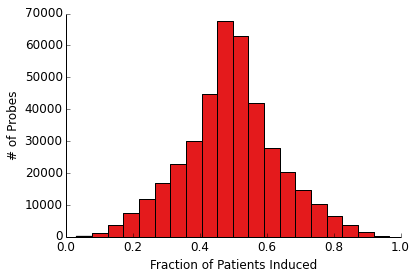

In [8]:
fig, ax = subplots(figsize=(6,4))
tab.frac.hist(ax=ax, bins=20)
ax.set_xlabel('Fraction of Patients Induced')
ax.set_ylabel('# of Probes')
prettify_ax(ax)

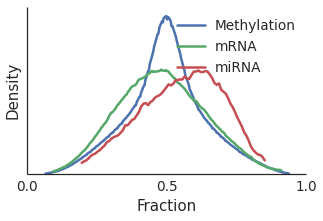

In [176]:
fig, ax = subplots(1,1, figsize=(5,3))
draw_dist(tab.frac, ax=ax, lw=2.5)
draw_dist(dx_genes.frac, ax=ax, lw=2.5, bins=200)
draw_dist(dx_mir.frac, ax=ax, lw=2.5, bins=100)


ax.set_yticks([])
ax.set_xticks([0,.5,1])
ax.set_ylabel('Density')
ax.set_xlabel('Fraction')
ax.legend(('Methylation','mRNA','miRNA'))
prettify_ax(ax)

In [9]:
cd ../Methlation/

/cellar/users/agross/TCGA_Code/Methlation


In [10]:
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [11]:
from Setup.DX_Imports import *

importing IPython notebook from Setup/DX_Imports

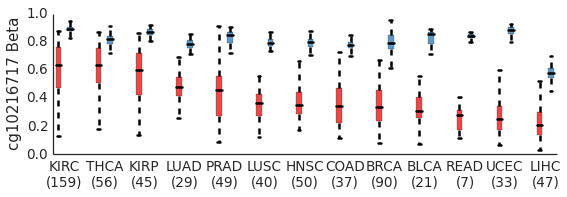

In [12]:
paired_bp_tn_split(matched_tn.ix['cg10216717'], codes, data_type='Beta')

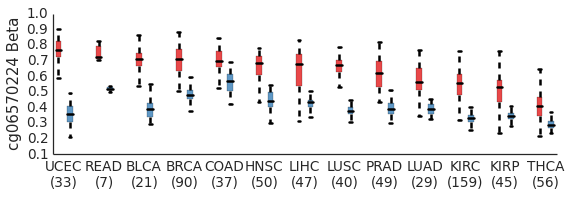

In [13]:
paired_bp_tn_split(matched_tn.ix['cg06570224'], codes, data_type='Beta')

In [14]:
def manhattan(vec, chrom, coords, ax=None, ybound=None,
              flow='up', ticks=True, gap=3e7):
    fig, ax = init_ax(ax, figsize=(9,3))
    x = 0
    chr_coords = []
    for i,c in enumerate(map(str, range(1,23))):
        v = vec.ix[ti(chrom == c)].dropna()
        series_scatter(coords + x, v, s=10, ax=ax, 
                       color=colors[i % 5], 
                       ann=None, alpha=1) 
        chr_len = coords.ix[v.index].max()
        x = x + chr_len + gap
        chr_coords += [x - (chr_len / 2.)]
    ax.set_xbound(gap, x + gap)
    if ybound is not None:
        ax.set_ybound(ybound[0],ybound[1])
    ax.set_xlabel('Chromosome')
    
    if ticks:
        ax.set_xticks(chr_coords)
        ax.set_xticklabels(map(str, range(1,23)))
    else:
        ax.set_xticks([])
    top = flow == 'down'
    prettify_ax(ax, top)

In [15]:
ann = probe_annotations
ann.Genomic_Coordinate = ann.Genomic_Coordinate.astype(float)
ann = ann.ix[tab.index.intersection(ann.index)]
ann = ann.sort(['Chromosome','Genomic_Coordinate'])

In [16]:
hits = tab.frac > .5
print hits.value_counts()

m = hits.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               hits.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

False    207995
True     188070
dtype: int64


In [17]:
w = 20
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               tab.frac.ix[ann.index].groupby(ann.Chromosome)]).dropna()
z_roll = (v - v.mean()) / v.std()
z_roll.name = 'z'

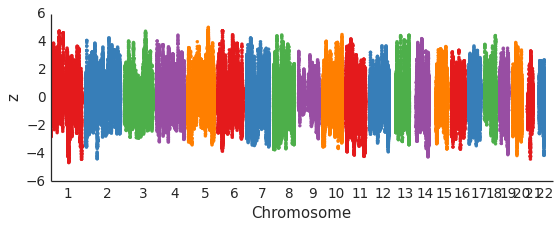

In [18]:
manhattan(z_roll, ann.Chromosome, ann.Genomic_Coordinate)

In [19]:
dd = ann.join(z_roll).sort('z')
g = dd[dd.z.abs() > 3].Gene_Symbol.dropna().unique()
g = list({c for l in g for c in l.split(';')})

In [20]:
compare_tn = lambda s: s.ix[:, '01'] > s.ix[:, '11']

In [21]:
aa = (dx_genes.frac - .5).abs()
genes = ti((aa > .25) & (aa < .45))
bb = (tab.frac - .5).abs()
probes = ti((bb > .25) & (bb < .45))

In [22]:
%%time
df = ann.ix[probes].dropna()
df = df[df.Gene_Symbol.isin(genes)]
r = pd.DataFrame({s: fisher_exact_test(compare_tn(matched_rna.ix[v.Gene_Symbol]),
                                       compare_tn(matched_tn.ix[s]))
                  for s,v in df.iterrows()}).T

CPU times: user 54.9 s, sys: 31.9 ms, total: 55 s
Wall time: 55.1 s


In [23]:
dr = matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)
dm = matched_tn.xs('01',1,1) > matched_tn.xs('11',1,1)
gene_lookup = ann.Gene_Symbol.dropna()
gene_lookup = gene_lookup[gene_lookup.isin(dr.index)]
dm = dm.ix[gene_lookup.index]
dr = dr.ix[:, dr.columns.intersection(dm.columns)]
dm = dm.ix[:, dr.columns.intersection(dm.columns)]

In [24]:
dr_x = dr.ix[gene_lookup]
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index]

a11 = sum(dr_x & dm_x, 1)
a10 = sum(dr_x & (dm_x == False), 1)
a01 = sum((dr_x == False) & dm_x, 1)
a00 = sum((dr_x == False) & (dm_x == False), 1)
odds_ratio = (1.*a11 * a00) / (1.*a10 * a01)

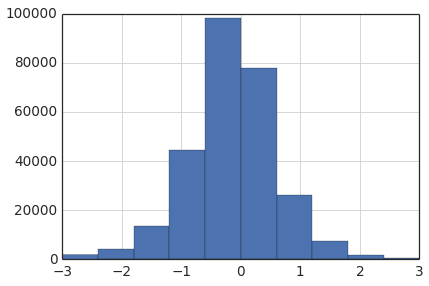

In [25]:
log_odds = np.log2(odds_ratio).clip(-3,3)
log_odds.hist()

In [26]:
import Setup.DX_Imports as DX

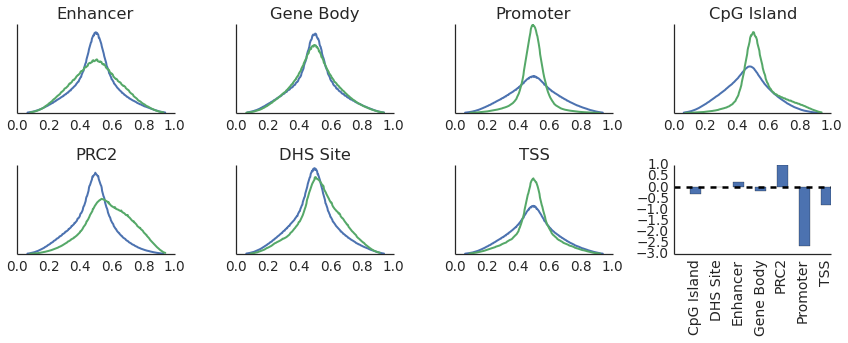

In [27]:
fig, axs = subplots(2,4, figsize=(12,5))
axs = axs.flatten()
for i,p in enumerate(DX.probe_sets.keys()):
    draw_dist(tab.frac, DX.probe_sets[p], ax=axs[i])
    axs[i].legend().set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_title(p)
    prettify_ax(axs[i])
f_odds = pd.DataFrame({f: fisher_exact_test((tab.frac - .5).abs() > .25, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[-1])
prettify_ax(axs[-1])
fig.tight_layout()

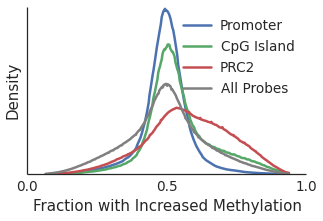

In [92]:
fig, ax = subplots(1,1, figsize=(5,3))
lw = 2.5
draw_dist(tab.frac.ix[ti(DX.probe_sets['Promoter'])], ax=ax, lw=lw)
draw_dist(tab.frac.ix[ti(DX.probe_sets['CpG Island'])], ax=ax, lw=lw)
draw_dist(tab.frac.ix[ti(DX.probe_sets['PRC2'])], ax=ax, lw=lw)
draw_dist(tab.frac, ax=ax, colors='grey', lw=lw)
ax.set_yticks([])
ax.set_xticks([0,.5,1])
ax.set_ylabel('Density')
ax.set_xlabel('Fraction with Increased Methylation')
ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
prettify_ax(ax)

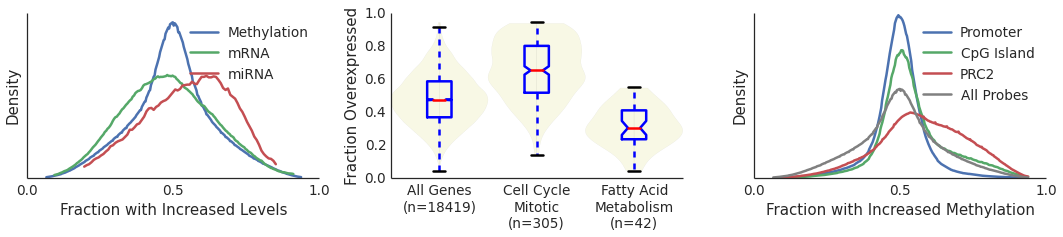

In [222]:
fig, axs = subplots(1,3, figsize=(15,3.5))

ax = axs[0]
draw_dist(tab.frac, ax=ax, lw=2.5)
draw_dist(dx_genes.frac, ax=ax, lw=2.5, bins=200)
draw_dist(dx_mir.frac, ax=ax, lw=2.5, bins=100)


ax.set_yticks([])
ax.set_xticks([0,.5,1])
ax.set_ylabel('Density')
ax.set_xlabel('Fraction with Increased Levels')
ax.legend(('Methylation','mRNA','miRNA'))
prettify_ax(ax)

ax = axs[1]
v = pd.concat([dx_genes.frac, 
               dx_genes.frac.ix[ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)],
               dx_genes.frac.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)]])

v1 = pd.concat([pd.Series('All Genes', dx_genes.frac.index), 
                pd.Series('Cell Cycle\nMitotic', ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)),
                pd.Series('Fatty Acid\nMetabolism', ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0))])
v1.name = ''
v.name = 'Fraction Overexpressed'
violin_plot_pandas(v1, v, ann=None, ax=ax)
prettify_ax(ax)

ax=axs[2]
lw = 2.5
draw_dist(tab.frac.ix[ti(DX.probe_sets['Promoter'])], ax=ax, lw=lw)
draw_dist(tab.frac.ix[ti(DX.probe_sets['CpG Island'])], ax=ax, lw=lw)
draw_dist(tab.frac.ix[ti(DX.probe_sets['PRC2'])], ax=ax, lw=lw)
draw_dist(tab.frac, ax=ax, colors='grey', lw=lw)
ax.set_yticks([])
ax.set_xticks([0,.5,1])
ax.set_ylabel('Density')
ax.set_xlabel('Fraction with Increased Methylation')
ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
prettify_ax(ax)
fig.tight_layout()

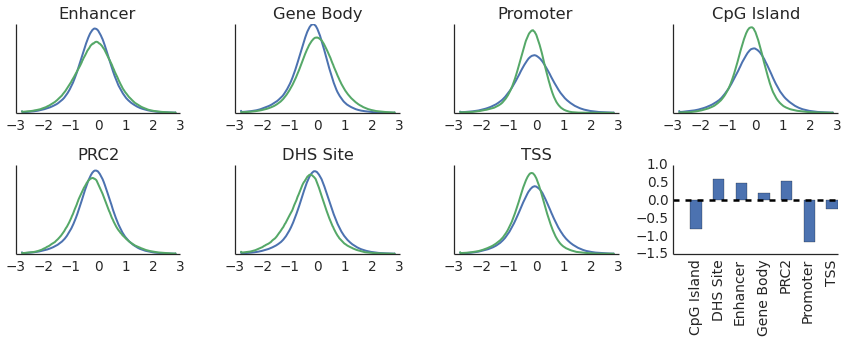

In [28]:
fig, axs = subplots(2,4, figsize=(12,5))
axs = axs.flatten()
for i,p in enumerate(DX.probe_sets.keys()):
    draw_dist(log_odds, DX.probe_sets[p], ax=axs[i])
    axs[i].legend().set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_title(p)
    prettify_ax(axs[i])
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds.abs().dropna() > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[-1])
prettify_ax(axs[-1])
fig.tight_layout()

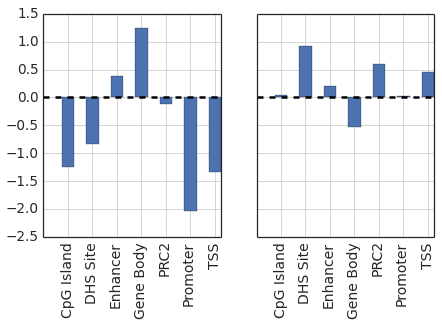

In [68]:
fig, axs = subplots(1,2, figsize=(7,4), sharey=True)
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds > .5, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[0])

f_odds = pd.DataFrame({f: fisher_exact_test(log_odds < -.5, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[1])

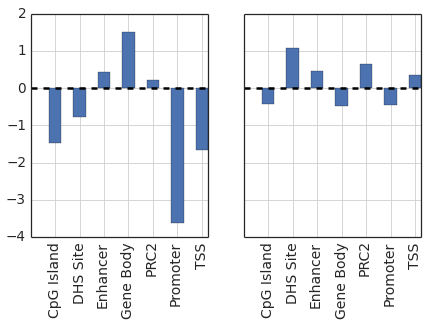

In [29]:
fig, axs = subplots(1,2, figsize=(7,4), sharey=True)
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[0])

f_odds = pd.DataFrame({f: fisher_exact_test(log_odds < -1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[1])

In [30]:
m = log_odds.groupby(gene_lookup).mean().dropna().order()
s = log_odds.groupby(gene_lookup).size()
s = s[s.index.isin(dx_genes.index)]
g = m.ix[ti(s > 10)]
pd.concat([g,s], keys=['g','s'], axis=1).dropna().sort('g').tail(10)

,g,s
C20orf160,1.28,15
CDH4,1.31,90
HOTAIR,1.32,16
PTPRN2,1.40,1051
TBL1Y,1.46,11
KNDC1,1.48,115
RHPN1,1.52,23
RASAL3,1.53,13
RIMBP2,1.58,98
WIT1,1.73,14


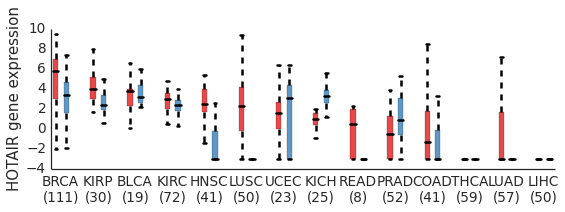

In [31]:
paired_bp_tn_split(rna_df.ix['HOTAIR'], codes)

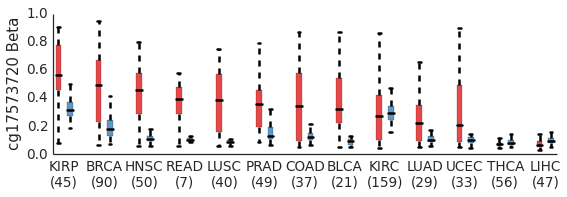

In [32]:
paired_bp_tn_split(matched_tn.ix['cg17573720'], codes, data_type='Beta')

In [33]:
v = odds_ratio.ix[ti(gene_lookup == 'HOTAIR')].order()
v

Hybridization REF
cg02665037           0.74
cg06850442           1.40
cg24895871           1.86
cg20116805           1.96
cg11328436           2.13
cg22829917           2.17
cg18824990           2.38
cg16006349           2.46
cg00079219           2.73
cg10641615           3.35
cg15731655           3.42
cg18040901           3.53
cg14691529           3.67
cg05516489           3.72
cg06622953           3.80
cg17573720           3.88
dtype: float64

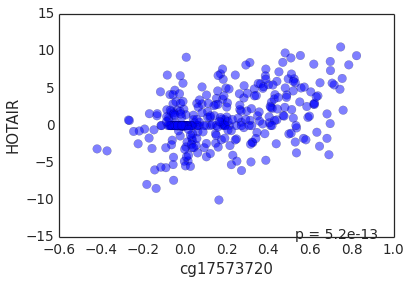

In [34]:
v1 = matched_tn.ix['cg17573720']
v1 = v1[:, '01'] - v1[:, '11']

v2 = matched_rna.ix['HOTAIR']
v2 = v2[:, '01'] - v2[:, '11']
series_scatter(v1, v2)

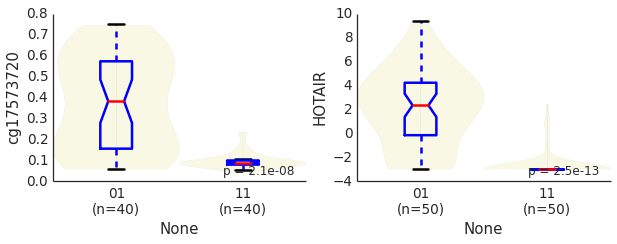

In [35]:
fig, axs = subplots(1,2, figsize=(10,3))
violin_plot_series(matched_tn.ix['cg17573720'].ix[ti(codes=='LUSC')], ax=axs[0])
violin_plot_series(matched_rna.ix['HOTAIR'].ix[ti(codes=='LUSC')], ax=axs[1])
for ax in axs:
    prettify_ax(ax)

In [36]:
path = '/cellar/users/agross/TCGA_Code/TCGA/Data/Firehose__2014_07_15/'
cn_all = {}
for c in codes.unique():
    try:
        cn_all[c] = FH.get_gistic_gene_matrix(path, c)
    except:
        print c
cn_all = pd.concat(cn_all.values(), axis=1)
cn_all = cn_all.groupby(axis=1, level=0).first()
cn_all.index = cn_all.index.get_level_values(2)

In [37]:
dr = matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)
dm = matched_tn.xs('01',1,1) > matched_tn.xs('11',1,1)
dc = cn_all
genes = dr.index.intersection(dc.index)
genes = genes.intersection(ann.Gene_Symbol.dropna().unique())
gene_lookup = ann.Gene_Symbol.dropna()
gene_lookup = gene_lookup[gene_lookup.isin(genes)]
pts = dr.columns.intersection(dm.columns).intersection(dc.columns)
genes = dr.index.intersection(dc.index)
dr = dr.ix[genes, pts]
dc = dc.ix[genes, pts]
dm = dm.ix[gene_lookup.index, pts]
#dm = dm.ix[gene_lookup.index, pts]

In [38]:
dr_masked = dr.mask(dc != 0)
dr_x = dr_masked.ix[gene_lookup]
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index]

a11 = sum(dr_x.add(dm_x) == 2, 1)
a10 = sum(dr_x.add(dm_x == False) == 2, 1)
a01 = sum((dr_x == False).add(1.*dm_x) == 2, 1)
a00 = sum((1.*(dr_x == False)).add(dm_x == False) == 2, 1)
odds_ratio_m = (1.*a11 * a00) / (1.*a10 * a01)

log_odds_m = np.log2(odds_ratio_m).clip(-3,3).dropna()

/cellar/users/agross/anaconda2/lib/python2.7/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


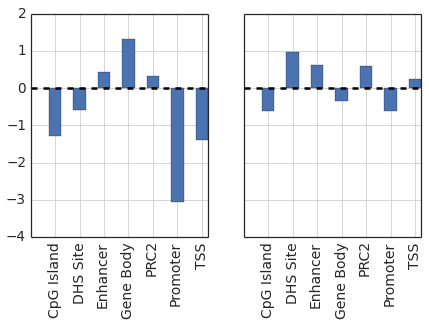

In [39]:
fig, axs = subplots(1,2, figsize=(7,4), sharey=True)
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[0])

f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m < -1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[1])

In [40]:
pd.concat?

In [41]:
def odds_ratio_df(a,b):
    a = a * 1.
    b = b * 1.
    flip = lambda v: (v == 0).astype(int)
    
    a11 = sum(a.add(b) == 2, 1)
    a10 = sum(a.add(flip(b)) == 2, 1)
    a01 = sum(flip(a).add(b) == 2, 1)
    a00 = sum(flip(a).add(flip(b)) == 2, 1)
    odds_ratio = (1.*a11 * a00) / (1.*a10 * a01)
    df = pd.concat([a00, a01, a10, a11], axis=1,
                   keys=['00','01','10','11'])
    return odds_ratio, df

In [42]:
dr_masked = dr.mask(dc >= 0)
dr_x = dr_masked.ix[gene_lookup] * 1.
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index] * 1.
odds_del, df_del = odds_ratio_df(dr_x, dm_x)

In [43]:
dr_masked = dr.mask(dc <= 0)
dr_x = dr_masked.ix[gene_lookup] * 1.
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index] * 1.
odds_amp, df_amp = odds_ratio_df(dr_x, dm_x)

In [44]:
dr_masked = dr.mask(dc != 0)
dr_x = dr_masked.ix[gene_lookup] * 1.
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index] * 1.
odds_wt, df_wt = odds_ratio_df(dr_x, dm_x)

In [45]:
p = ti(((df_wt.sum(1) > 50) & (df_del.sum(1) > 1)))

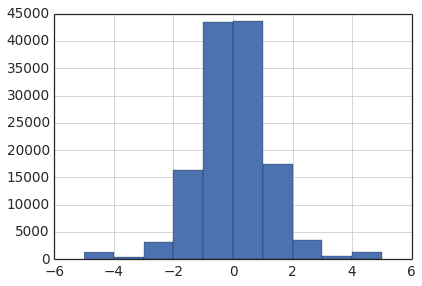

In [122]:
(np.log2(odds_wt.ix[p]) - np.log2(odds_del.ix[p])).clip(-5,5).hist()

In [ ]:
series_scatter(np.log2(odds_wt.ix[p]), np.log2(odds_del.ix[p]))
plt.plot([-4,4],[-4,4])

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/kernel/zmq/ipkernel.py", 

In [82]:
dr_masked = dr.mask(dc >= 0)
dr_x = dr_masked.ix[gene_lookup] * 1.
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index] * 1.

a11 = sum(dr_x.add(dm_x) == 2, 1)
a10 = sum(dr_x.add(dm_x == 0) == 2, 1)
a01 = sum((dr_x == 0).add(1.*dm_x) == 2, 1)
a00 = sum((1.*(dr_x == 0)).add(dm_x == 0) == 2, 1)
odds_ratio_m = (1.*a11 * a00) / (1.*a10 * a01)

log_odds_m = np.log2(odds_ratio_m).clip(-3,3).dropna()

In [79]:
log_odds_m2 = log_odds_m.ix[(a11 + a00 + a01 + a10) > 80]

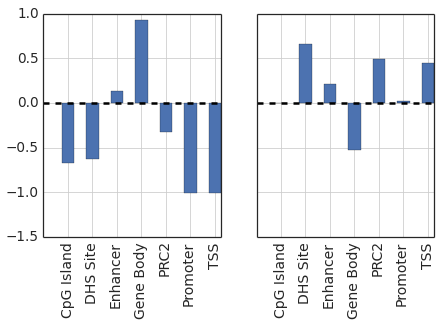

In [80]:
fig, axs = subplots(1,2, figsize=(7,4), sharey=True)
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m2 > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[0])

f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m2 < -1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[1])

In [43]:
dr_masked = dr.mask(dc <= 0)
dr_x = dr_masked.ix[gene_lookup]
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index]

a11 = sum(dr_x.add(dm_x) == 2, 1)
a10 = sum(dr_x.add(dm_x == False) == 2, 1)
a01 = sum((dr_x == False).add(1.*dm_x) == 2, 1)
a00 = sum((1.*(dr_x == False)).add(dm_x == False) == 2, 1)
odds_ratio_m = (1.*a11 * a00) / (1.*a10 * a01)

log_odds_m = np.log2(odds_ratio_m).clip(-3,3).dropna()

In [75]:
log_odds_m2 = log_odds_m.ix[(a11 + a00 + a01 + a10) > 80]

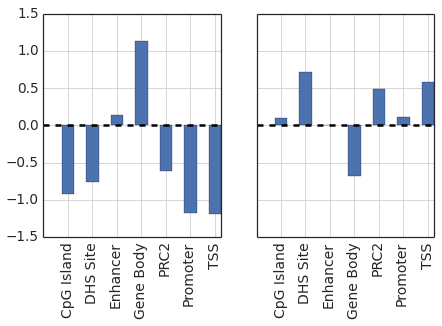

In [76]:
fig, axs = subplots(1,2, figsize=(7,4), sharey=True)
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m2 > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[0])

f_odds = pd.DataFrame({f: fisher_exact_test(log_odds_m2 < -1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[1])

In [659]:
linear_regression(log_odds, log_odds_m)

intercept    1.58e-02
p-value      0.00e+00
r-value      9.15e-01
slope        9.41e-01
stderr       7.99e-04
dtype: float64

In [47]:
log_odds_m.ix['cg14735329']

-3.0

In [60]:
gene_lookup.ix['cg14735329']

'GABRA6'

In [63]:
fisher_exact_test(dr.ix['GABRA6'], dm.ix['cg14735329'])

odds_ratio    8.75e+00
p             1.07e-10
dtype: float64

In [68]:
fisher_exact_test(dr.ix['GABRA6'].ix[ti(dc.ix['GABRA6'] > 0)], dm.ix['cg14735329'])

odds_ratio    0
p             1
dtype: float64

In [54]:
dr_x.ix['cg14735329'].dropna()

TCGA-44-2665    0
TCGA-44-5645    0
TCGA-50-5935    0
TCGA-A6-2679    0
TCGA-A6-2685    0
TCGA-A7-A13F    0
TCGA-AZ-6598    0
TCGA-B0-4712    0
TCGA-B0-5402    0
TCGA-B0-5711    0
TCGA-B0-5712    0
TCGA-BC-A10Q    0
TCGA-BC-A10T    0
TCGA-BC-A10W    0
TCGA-BC-A216    0
...
TCGA-DD-A118    0
TCGA-DD-A119    0
TCGA-DD-A11D    0
TCGA-DD-A1EE    0
TCGA-DD-A39V    0
TCGA-DD-A39W    0
TCGA-DD-A39X    0
TCGA-DD-A3A1    0
TCGA-DD-A3A3    0
TCGA-E9-A1N6    0
TCGA-E9-A1RD    0
TCGA-E9-A1RF    0
TCGA-EJ-7789    1
TCGA-EM-A1YC    0
TCGA-ES-A2HT    0
Name: cg14735329, Length: 62, dtype: float64

In [52]:
pd.crosstab(dm_x.ix['cg14735329'], dr_x.ix['cg14735329'])

KeyError: 'Level cg14735329 not found'

In [46]:
(log_odds_m - log_odds).order().dropna()

Hybridization REF
cg14735329          -6.00
cg17296650          -6.00
cg16459667          -6.00
cg05939560          -6.00
cg19537070          -5.98
cg10063169          -5.91
cg15858166          -5.82
cg13804738          -5.80
cg04062767          -5.78
cg17138769          -5.75
cg01558877          -5.68
cg11053663          -5.65
cg15026456          -5.61
cg22672790          -5.59
cg09077934          -5.58
...
cg13842648           5.20
cg13702185           5.20
cg20832320           5.22
cg07091481           5.25
cg04951797           5.25
cg08925046           5.41
cg14623715           5.48
cg22234930           5.48
cg06499647           5.52
cg07216529           5.62
cg15850390           5.65
cg14535980           5.78
cg21838979           5.97
cg05989312           6.00
cg24327132           6.00
Length: 265556, dtype: float64

In [26]:
%%time
df = ann.ix[tab.p.order().index[:10000]].dropna()
df = df[df.Gene_Symbol.isin(cn_all.index)]
r = pd.DataFrame({s: fisher_exact_test(cn_all.ix[v.Gene_Symbol]>0,
                                       compare_tn(matched_tn.ix[s]))
                  for s,v in df.iterrows()}).T

CPU times: user 2min, sys: 19.3 ms, total: 2min
Wall time: 2min


In [27]:
r['q'] = r.p * len(r.p)
r.sort('p').head()

,odds_ratio,p,q
cg24020826,0.11,1.15e-14,6.32e-11
cg11229513,8.29,1.31e-13,7.17e-10
cg27029821,8.68,3.73e-13,2.05e-09
cg04812644,0.15,5.41e-12,2.97e-08
cg10222925,0.14,9.34e-12,5.13e-08


In [28]:
r.join(ann).sort('p').head(10)

,odds_ratio,p,q,Gene_Symbol,Chromosome,Genomic_Coordinate
cg24020826,0.11,1.15e-14,6.32e-11,KCNK9,8,1.41e+08
cg11229513,8.29,1.31e-13,7.17e-10,PRDM14,8,7.10e+07
cg27029821,8.68,3.73e-13,2.05e-09,PRDM14,8,7.10e+07
cg04812644,0.15,5.41e-12,2.97e-08,LOC286094,8,1.36e+08
cg10222925,0.14,9.34e-12,5.13e-08,DCAF4L2,8,8.89e+07
cg17057086,0.11,9.98e-12,5.48e-08,KCNQ3,8,1.33e+08
cg21255438,6.62,2.72e-11,1.49e-07,PRDM14,8,7.10e+07
cg15707869,0.15,5.25e-11,2.88e-07,DCAF4L2,8,8.89e+07
cg21367256,0.15,2.52e-10,1.39e-06,MYT1,20,6.28e+07
cg10242032,8.27,3.22e-10,1.77e-06,LOC388692,1,1.49e+08


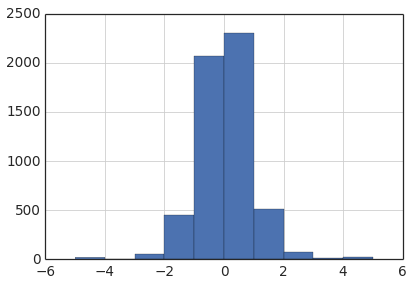

In [110]:
np.log2(r.odds_ratio).clip(-5,5).hist()

In [117]:
pd.crosstab(compare_tn(matched_tn.ix['cg11229513']),
                  cn_all.ix['PRDM14'])

PRDM14,-1.0,0.0,1.0,2.0
cg11229513,,,,
False,9,96,7,2
True,31,301,213,23


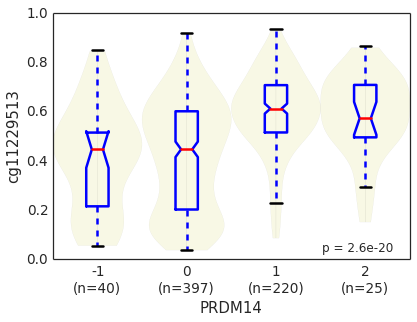

In [139]:
violin_plot_pandas(cn_all.ix['PRDM14'], matched_tn.ix['cg11229513'][:,'01'], 
                   order=[-1,0,1,2])

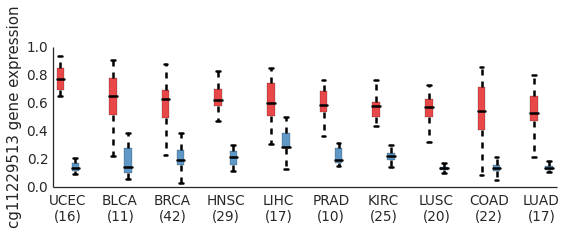

In [132]:
paired_bp_tn_split(matched_tn.ix['cg11229513'], codes.ix[ti(cn_all.ix['PRDM14']==1)])

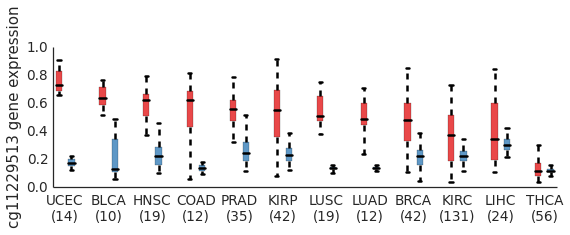

In [121]:
paired_bp_tn_split(matched_tn.ix['cg11229513'], codes.ix[ti(cn_all.ix['PRDM14']<=0)])

In [66]:
cn_all.ix['PTPRN2'].value_counts()

 0    4909
 1    2833
-1     852
 2     200
-2      60
dtype: int64

In [80]:
pd.crosstab(cn_all.ix['PTPRN2']>0,
            [compare_tn(matched_tn.ix['cg22420514']),
            compare_tn(matched_rna.ix['PTPRN2'])],
           rownames=['cn'], colnames=['meth','exp']).stack().stack().ix[1].unstack()

meth,False,True
exp,,
False,60,1
True,26,19


In [71]:
fisher_exact_test(compare_tn(matched_tn.ix['cg22420514']).ix[ti(cn_all.ix['PTPRN2']>0)],
                  compare_tn(matched_rna.ix['PTPRN2']))

odds_ratio    4.38e+01
p             7.81e-08
dtype: float64

In [81]:
fisher_exact_test(compare_tn(matched_tn.ix['cg22420514']).ix[ti(cn_all.ix['PTPRN2']==0)],
                  compare_tn(matched_rna.ix['PTPRN2']))

odds_ratio    1.45e+01
p             1.60e-13
dtype: float64

In [70]:
fisher_exact_test(compare_tn(matched_tn.ix['cg22420514']),
                  compare_tn(matched_rna.ix['PTPRN2']))

odds_ratio    1.69e+01
p             4.70e-22
dtype: float64

In [26]:
ct = pd.crosstab(compare_tn(matched_rna.ix['LOC134466']),
                 compare_tn(matched_tn.ix['cg05016408']))
ct

cg05016408,False,True
LOC134466,,
False,25,262
True,39,35


In [381]:
ct.sum(1) / ct.sum().sum()

LOC134466
False        0.8
True         0.2
dtype: float64

In [380]:
ct.sum() / ct.sum().sum()

cg05016408
False         0.18
True          0.82
dtype: float64

In [358]:
(262.) / (262 + 39)

0.8704318936877077

In [356]:
(25. * 35) / (262 * 39)

0.08563319632021922

In [374]:
r = pd.DataFrame({s: fisher_exact_test(compare_tn(matched_rna.ix['PTPRN2']),
                                       compare_tn(matched_tn.ix[s]))
                  for s in ti(ann.Gene_Symbol.dropna().str.contains('PTPRN2'))}).T

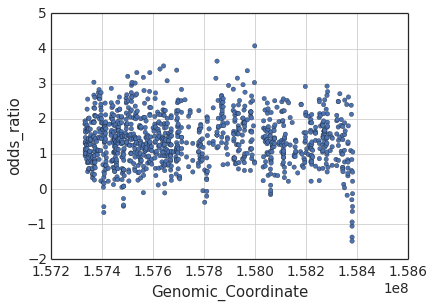

In [375]:
ann.ix[r.index].join(np.log2(r.odds_ratio)).sort('Genomic_Coordinate').plot(x='Genomic_Coordinate',y='odds_ratio',
                                                                  kind='scatter')

In [240]:
r.sort('p').head()

,odds_ratio,p
cg11005651,4.33,1.58e-05
cg25962829,4.33,1.83e-05
cg04182226,3.99,6.88e-05
cg19268434,4.08,8.18e-05
cg14218053,0.28,1.19e-04


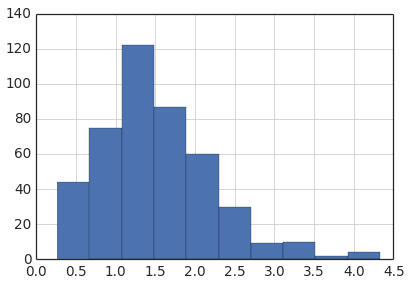

In [238]:
r.odds_ratio.hist()

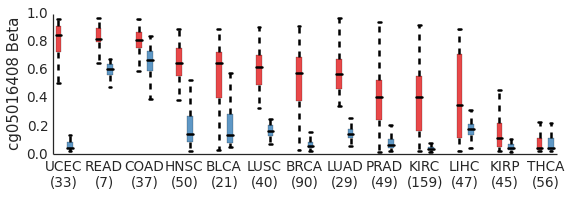

In [351]:
paired_bp_tn_split(matched_tn.ix['cg05016408'], codes, data_type='Beta')

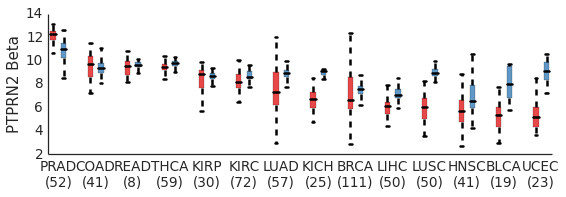

In [376]:
paired_bp_tn_split(matched_rna.ix['PTPRN2'], codes, data_type='Beta')

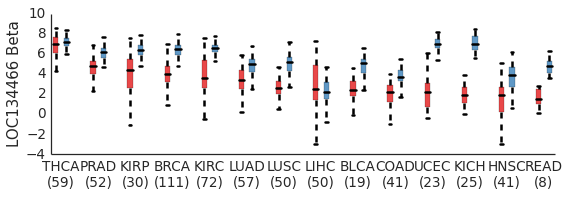

In [350]:
paired_bp_tn_split(matched_rna.ix['LOC134466'], codes, data_type='Beta')

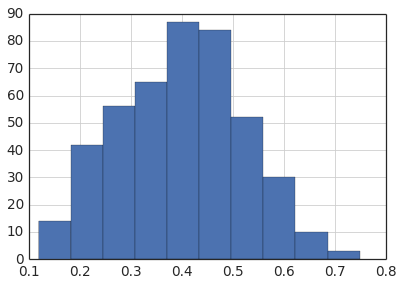

In [200]:
tab.ix[ann[ann.Gene_Symbol == 'TNXB'].index].frac.hist()

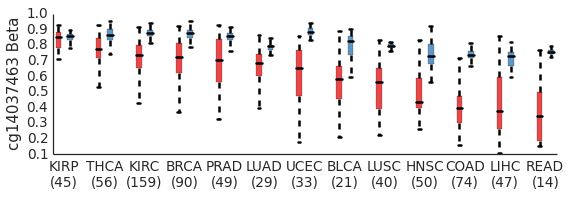

In [199]:
paired_bp_tn_split(matched_tn.ix['cg14037463'], codes, data_type='Beta')

In [184]:
len(g)

534